# ✅ 标签重用

## 🔳 基本代码

In [1]:
%matplotlib inline

import os
import torch
import torchvision
from torch import nn
import d2l_torch as d2l

In [3]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [4]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
train_imgs.classes,train_imgs.class_to_idx["hotdog"]

(['hotdog', 'not-hotdog'], 0)

In [5]:
normalize=torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_augs=torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
                                          torchvision.transforms.RandomHorizontalFlip(),
                                          torchvision.transforms.ToTensor(),
                                          normalize])

test_augs=torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                         torchvision.transforms.RandomCrop(224),
                                         torchvision.transforms.ToTensor(),
                                         normalize])

In [6]:
def train_fine_tuning(net,lr,batch_size=128,num_epochs=5,param_group=True):
    """
    大部分和之前都差不多，不过有一个param_group，用来区分fc层和其它层学习率的参数
    非fc层是小的学习率，fc层的学习率是其它层的学习率的10倍
    因此非fc层是 1x，而fc层是10x（表示1倍学习率和10倍学习率）
    """
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),transform=test_augs),
        batch_size=batch_size)
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none") 
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        trainer=torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(),'lr': lr * 10}],lr=lr,weight_decay=0.001)
    else:
        trainer=torch.optim.SGD(net.parameters(),lr=lr,weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

## 🔳 模型定义（关键部分）

### ☑ 使用预训练模型相同标签的权重初始化

**只需要weight，不需要bias**
```python
(fc): Linear(in_features=512, out_features=1000, bias=True)
```

+ 打印出resnet结构，可以看到，其实fc层除了`fc.weight`，其实也有`fc.bias`的

In [7]:
finetune_net=torchvision.models.resnet18(pretrained=True)

In [8]:
finetune_net.fc.weight.shape,finetune_net.fc.weight[934,:].shape

(torch.Size([1000, 512]), torch.Size([512]))

In [9]:
weight = finetune_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
print(hotdog_w.shape)

torch.Size([1, 512])


In [12]:
weight[934].shape

torch.Size([512])

In [13]:
weight

Parameter containing:
tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
        [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
        [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
        ...,
        [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
        [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
        [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
       requires_grad=True)

In [11]:
finetune_net.fc=nn.Linear(finetune_net.fc.in_features,2) 
nn.init.xavier_uniform_(finetune_net.fc.weight) # 先初始化，再赋值标号相同的权重
print(finetune_net.fc.weight.data.shape)

torch.Size([2, 512])


In [ ]:
finetune_net.fc.weight.data[0]=hotdog_w

### ☑训练结果

loss 0.177, train acc 0.934, test acc 0.944
150.5 examples/sec on [device(type='cuda', index=0)]


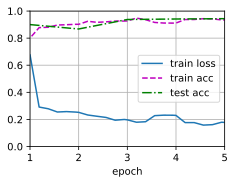

In [15]:
train_fine_tuning(finetune_net, batch_size=64,lr=5e-5)

# ✅ 冻结特征抽取部分

参考pytorch的form：[How to modify the final FC layer based on the torch.model](https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766)

```python
model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(512, 8) # assuming that the fc7 layer has 512 neurons, otherwise change it 
model.cuda()
```

+ 最关键的其实就是`param.requires_grad = False`，把特征层部分的参数设置成不可训练（没有梯度）。。。
+ 另外，虽然上面的for循环把所有参数（包括最后一层的参数）也设置成了 没有梯度，
+ 但是pytorch默认新构建的层，`requires_grad=True`，所以不需要再进行手动设置
+ 另外，可以使用`gg19.classifier._modules['6'] = nn.Linear(4096, 8)`这种方式来临时对网络中的层进行替换。。。

In [16]:
finetune_net=torchvision.models.resnet18(pretrained=True)
for param in finetune_net.parameters():
    param.requires_grad = False
# 冻结所有层


finetune_net.fc=nn.Linear(finetune_net.fc.in_features,2) 

# 重新初始化fc层，pytorch默认新构建的层，requires_grad=True，所以只训练fc层，应该速度会更快
nn.init.xavier_uniform_(finetune_net.fc.weight) 

Parameter containing:
tensor([[ 0.0389, -0.0795,  0.0275,  ...,  0.0553,  0.0119,  0.0860],
        [ 0.0468, -0.0430,  0.0277,  ...,  0.0243,  0.0714, -0.0675]],
       requires_grad=True)

loss 0.272, train acc 0.887, test acc 0.901
432.4 examples/sec on [device(type='cuda', index=0)]


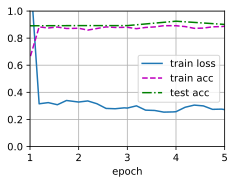

In [17]:
train_fine_tuning(finetune_net, batch_size=64,lr=5e-5)

# ✅ 其他知识

## 🔳 torch.split

In [4]:
a = torch.arange(10).reshape(5,2)
a

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [5]:
torch.split(a, 2)

(tensor([[0, 1],
         [2, 3]]),
 tensor([[4, 5],
         [6, 7]]),
 tensor([[8, 9]]))

In [7]:
torch.split(a, [1,4])

(tensor([[0, 1]]),
 tensor([[2, 3],
         [4, 5],
         [6, 7],
         [8, 9]]))

## 🔳 访问参数

### ☑ 打印网络

In [8]:
finetune_net=torchvision.models.resnet18(pretrained=True)

In [9]:
type(finetune_net)

torchvision.models.resnet.ResNet

In [54]:
finetune_net.layer1[0].conv1.state_dict()['weight'].shape

torch.Size([64, 64, 3, 3])

In [10]:
finetune_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### ☑ named_parameters使用

In [14]:
dict(finetune_net.named_parameters()).keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'layer3.0.conv2.weight', 'layer3.0.bn2.weight', 'layer3.0.bn2.bias', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.1.conv1.weight', 'layer3.1.bn1.weight', 'layer3.1.bn1.bias', 

In [21]:
for name, param in finetune_net.named_parameters():
    if 'bias' in name:
        print(f"含有偏置项，即bias=True的层有：{name}，同时参数的大小为：{param.size()}")

含有偏置项，即bias=True的层有：bn1.bias，同时参数的大小为：torch.Size([64])
含有偏置项，即bias=True的层有：layer1.0.bn1.bias，同时参数的大小为：torch.Size([64])
含有偏置项，即bias=True的层有：layer1.0.bn2.bias，同时参数的大小为：torch.Size([64])
含有偏置项，即bias=True的层有：layer1.1.bn1.bias，同时参数的大小为：torch.Size([64])
含有偏置项，即bias=True的层有：layer1.1.bn2.bias，同时参数的大小为：torch.Size([64])
含有偏置项，即bias=True的层有：layer2.0.bn1.bias，同时参数的大小为：torch.Size([128])
含有偏置项，即bias=True的层有：layer2.0.bn2.bias，同时参数的大小为：torch.Size([128])
含有偏置项，即bias=True的层有：layer2.0.downsample.1.bias，同时参数的大小为：torch.Size([128])
含有偏置项，即bias=True的层有：layer2.1.bn1.bias，同时参数的大小为：torch.Size([128])
含有偏置项，即bias=True的层有：layer2.1.bn2.bias，同时参数的大小为：torch.Size([128])
含有偏置项，即bias=True的层有：layer3.0.bn1.bias，同时参数的大小为：torch.Size([256])
含有偏置项，即bias=True的层有：layer3.0.bn2.bias，同时参数的大小为：torch.Size([256])
含有偏置项，即bias=True的层有：layer3.0.downsample.1.bias，同时参数的大小为：torch.Size([256])
含有偏置项，即bias=True的层有：layer3.1.bn1.bias，同时参数的大小为：torch.Size([256])
含有偏置项，即bias=True的层有：layer3.1.bn2.bias，同时参数的大小为：torch.Size([256])
含有偏置项，即bias=True的层有：l

In [ ]:
for name, param in finetune_net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [24]:
len(dict(finetune_net.named_parameters())['fc.weight']),len(dict(finetune_net.named_parameters())['fc.bias'])

(1000, 1000)

In [28]:
dict(finetune_net.named_parameters())['fc.weight']

Parameter containing:
tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
        [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
        [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
        ...,
        [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
        [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
        [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
       requires_grad=True)

### ☑ parameters使用

In [29]:
finetune_net.parameters()

<generator object Module.parameters at 0x000001EFEF9DDD48>

In [37]:
for param in finetune_net.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch

### ☑ state_dict使用

In [40]:
finetune_net.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [42]:
finetune_net.state_dict()['fc.weight'].shape

torch.Size([1000, 512])

In [31]:
dict(finetune_net.named_parameters())['fc.weight'].shape,dict(finetune_net.named_parameters())['fc.bias'].shape

(torch.Size([1000, 512]), torch.Size([1000]))

In [44]:
finetune_net.layer1._modules  # 字典格式

OrderedDict([('0',
              BasicBlock(
                (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (relu): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )),
             ('1',
              BasicBlock(
                (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (relu): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

所以其实对于嵌套的网络，也是可以不断访问内部的

In [45]:
finetune_net.layer1._modules['0']

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [47]:
finetune_net.layer1._modules['0'].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
finetune_net.layer1[0]

In [ ]:
finetune_net.fc._modules